In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup as bs
import requests
import seaborn as sns
%matplotlib inline  

#read csv files
dfShotsLog= pd.read_csv('shot_logs_2014_2015.csv')# file with shots log details
#remove unnecessary columns
dfShotsLog=dfShotsLog.drop(['MATCHUP','CLOSEST_DEFENDER_PLAYER_ID','PTS','player_id'],axis=1)
players_stats_2014_2015=pd.read_csv('players_stats_2014_2015.csv')# file with players details




In [2]:
#remove unnecessary columns
players_stats_2014_2015=players_stats_2014_2015.drop([ 'Games Played', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
'3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
'TOV', 'PF', 'EFF', 'AST/TOV', 'STL/TOV', 'Age','Birth_Place',
'Birthdate', 'Collage','Experience','Team','Weight',
'BMI'],axis=1)



In [3]:
#clean data
# function that gets input string (represents first name and last name )and indecation if reverse first name and last name
#return formated name
def formatPlayersName(inputString,isReverse=False):
    splitString=inputString.split()
    if(len(splitString)==1):
        return cleanStr(splitString[0],[".","-","'"])
    if(isReverse==True):
        newStr=cleanStr(splitString[1],[".","-",",","'"])+" "+cleanStr(splitString[0],[".","-",",","'"])
    else:
        newStr=cleanStr(splitString[0],[".","-",",","'"])+" "+cleanStr(splitString[1],[".","-",",","'"])
    
    return newStr
    
#help function that gets input string and list of chars to remove 
#return string with listChar removed
def cleanStr(inputString,listChar):
    newStr=inputString
    for char in listChar:
        newStr = newStr.replace(char, "")
    return newStr.lower()

# formating names in all columns that represent basket ball players name (we will use the names as key to merge data frame)
players_stats_2014_2015['Name'] = players_stats_2014_2015.apply(lambda x: formatPlayersName(x['Name']), axis=1)
dfShotsLog['player_name'] = dfShotsLog.apply(lambda x: formatPlayersName(x['player_name']), axis=1)
dfShotsLog['CLOSEST_DEFENDER'] = dfShotsLog.apply(lambda x: formatPlayersName(x['CLOSEST_DEFENDER'],True), axis=1)


In [4]:
# merging data 2 files based on players name (the data contain unique players names)
mergedWithShooterName=pd.merge(dfShotsLog, players_stats_2014_2015, how='inner', left_on=['player_name'], right_on=['Name'])
mergedWithDefenderName=pd.merge(mergedWithShooterName, players_stats_2014_2015, how='inner', left_on=['CLOSEST_DEFENDER'], right_on=['Name'])


In [5]:
#renaming data frame columns
mergedWithDefenderName.columns = ['GAME_ID','SHOOTERS_COURT_LOCATION', 'SHOOTERS_TEAM_FINAL_RESULT', 'SHOOTERS_FINAL_RESULT_DIFF', 'SHOT_NUMBER_IN_GAME', 'PERIOD',
       'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME','SHOT_DIST', 'PTS_TYPE',
       'SHOT_RESULT', 'DEFENDER_NAME','CLOSE_DEF_DIST','SHOT_RESULT_INT',
     'SHOOTER_NAME', 'SHOOTER_NAME_FROM_MERGE', 'SHOOTERS_HEIGHT',
    'SHOOTERS_POS', 'DEFENDER_NAME_FROM_MERGE', 'DEFENDER_HEIGHT',
      'DEFENDER_POS']
#remove unnecessary columns

dfWithRelevantColumns=mergedWithDefenderName.drop(['SHOOTER_NAME_FROM_MERGE','DEFENDER_NAME_FROM_MERGE'],axis=1)


In [6]:

#web site with list of left hand players
url = "http://www.apbr.org/lefties.html"
resp = requests.get(url)
soup = bs(resp.text, 'lxml')
players = soup.find(name='font').text.lower()
#adding to data columns that indicates if shooter/defender is left handed based on web site
dfWithRelevantColumns['SHOOTER_STRONG_HAND'] = dfWithRelevantColumns.apply(lambda x: 'LEFT' if x['SHOOTER_NAME'] in players else 'RIGHT', axis=1)
dfWithRelevantColumns['DEFENDER_STRONG_HAND'] = dfWithRelevantColumns.apply(lambda x: 'LEFT' if x['DEFENDER_NAME'] in players  else 'RIGHT', axis=1)



In [7]:
#reindex data frame with GAME_ID for performance Considerations for the following function
gameIdAsIndex=dfWithRelevantColumns.set_index('GAME_ID',drop=False)

#function that gets game_id data frame a record and break condition
#returns Sequence of basket made before current shot in current game if breakCondition=0
#returns Sequence of basket miss before current shot in current game if breakCondition=1

def calculateShotSequence(dfByGameId,record,breakCondition=0):
    if(record["SHOT_NUMBER_IN_GAME"]==1):
        return -1
    sortedDf=dfByGameId[(dfByGameId["SHOOTER_NAME"]==record["SHOOTER_NAME"]) & (dfByGameId["SHOT_NUMBER_IN_GAME"]<record["SHOT_NUMBER_IN_GAME"])][["SHOT_NUMBER_IN_GAME","SHOT_RESULT_INT"]].sort_values("SHOT_NUMBER_IN_GAME", ascending=False)
    count=0
    for index, row in sortedDf.iterrows():
        if(row["SHOT_RESULT_INT"]==breakCondition):
            break
        count=count+1
    return count

#adding column with information of Sequence of basket made before current shot in current game
gameIdAsIndex['SHOTS_IN_ROW'] = gameIdAsIndex.apply(lambda x: calculateShotSequence(gameIdAsIndex.loc[x["GAME_ID"]],x), axis=1)
#adding columns with information of Sequence of basket miss before current shot in current game
gameIdAsIndex['MISS_IN_ROW'] = gameIdAsIndex.apply(lambda x: calculateShotSequence(gameIdAsIndex.loc[x["GAME_ID"]],x,1), axis=1)



In [8]:
#sorting data frame by ["GAME_ID","SHOOTERS_NAME","SHOT_NUMBER_IN_GAME"]
gameIdAsIndex=gameIdAsIndex.sort_values(["GAME_ID","SHOOTER_NAME","SHOT_NUMBER_IN_GAME"])
#resteing index
dfReIndexef=gameIdAsIndex.reset_index(drop=True)
#saving data frame
dfReIndexef.to_csv("shotsLog.csv",index=False)


C:\Users\shaha\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'GAME_ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


In [9]:
#reading df
shotsLogDf= pd.read_csv('shotsLog.csv')
columnsWithNa=shotsLogDf.columns[shotsLogDf.isna().any()].tolist()
#removing rows where data is na
shotsLogDf = shotsLogDf.dropna(subset=columnsWithNa)
#saving data frame
shotsLogDf.to_csv("shotsLogFile.csv",index=False)


In [10]:
shotsLogDf= pd.read_csv('shotsLogFile.csv')
#convert feet to meter
shotsLogDf['SHOT_DIST'] = shotsLogDf.SHOT_DIST.apply(lambda x: x*0.3048)
#convert feet to meter
shotsLogDf['CLOSE_DEF_DIST'] = shotsLogDf.CLOSE_DEF_DIST.apply(lambda x:x*0.3048)
#converting time to seconds
shotsLogDf['GAME_CLOCK'] = shotsLogDf.GAME_CLOCK.apply(lambda x:int(x.split(":")[0])*60+int(x.split(":")[1]))
# creating columns with HEIGHT_DIFF
shotsLogDf['HEIGHT_DIFF']=shotsLogDf['SHOOTERS_HEIGHT']-shotsLogDf['DEFENDER_HEIGHT']


In [11]:
#function that returns if shot is money time (default is if shot was taken 150 seconds to end of game and final result is under 5)
def isMoneyTime(record,finalScoreDiff=3,secondsToEnd=120):
    if((record["PERIOD"]>4) | (record["PERIOD"]==4 & abs(int(record["SHOOTERS_FINAL_RESULT_DIFF"]))<=finalScoreDiff & record["GAME_CLOCK"]<=secondsToEnd)):
        return 1
    else:
        return 0
# creating columns with IS_MONEY_TIME value
shotsLogDf['IS_MONEY_TIME'] = shotsLogDf.apply(lambda x: isMoneyTime(x), axis=1)
shotsLogDf.to_csv("shotsLogData.csv",index=False)


In [12]:

shotsLogData= pd.read_csv('shotsLogData.csv')
#function that gets integer and number to round and returns rounded number
#example:roundNumber(5.3,0.5) will return 5.5  ,roundNumber(13,5) will return 5
def roundNumber(x,n):
    return round((1/float(n))*float(x))*n
def isHomeTeanWin(x):
    if((x.SHOOTERS_COURT_LOCATION=="H") & (x.SHOOTERS_FINAL_RESULT_DIFF>0)):
        return 1
    elif ((x.SHOOTERS_COURT_LOCATION=="A") & (x.SHOOTERS_FINAL_RESULT_DIFF<0)):
        return 1
    else:
        return 0
def isMoneyTimeGame(x,scoreDiff=5):
    if(abs(int(x["SHOOTERS_FINAL_RESULT_DIFF"]))<scoreDiff):
        return True
    else:
        return False             
    
    
#adding labeled columns
shotsLogData['HEIGHT_DIFF'] = shotsLogData.HEIGHT_DIFF.apply(lambda x: roundNumber(x,5))
shotsLogData['SHOT_CLOCK'] = shotsLogData.SHOT_CLOCK.apply(lambda x: roundNumber(x,0.5))
shotsLogData['DRIBBLES'] = shotsLogData.DRIBBLES.apply(lambda x: roundNumber(x,1))
shotsLogData['TOUCH_TIME'] = shotsLogData.TOUCH_TIME.apply(lambda x: roundNumber(x,1))
shotsLogData['SHOT_DIST'] = shotsLogData.SHOT_DIST.apply(lambda x: roundNumber(x,0.5))
shotsLogData['CLOSE_DEF_DIST'] = shotsLogData.CLOSE_DEF_DIST.apply(lambda x: roundNumber(x,0.5))
shotsLogData['SHOOTERS_TEAM_FINAL_RESULT'] = shotsLogData.SHOOTERS_TEAM_FINAL_RESULT.apply(lambda x: 1 if x=='W' else 0)
shotsLogData['IS_HOME_TEAM_WIN']=shotsLogData.apply(lambda x: isHomeTeanWin(x), axis=1)
shotsLogData['IS_MONEY_TIME_GAME']=shotsLogData.apply(lambda x: isMoneyTimeGame(x), axis=1)
#creating df per match includes game id,indication if home team won,indication if money time game
dfByMatch=shotsLogData.groupby(['GAME_ID', 'IS_HOME_TEAM_WIN','IS_MONEY_TIME_GAME']).count().reset_index()[['GAME_ID', 'IS_HOME_TEAM_WIN','IS_MONEY_TIME_GAME']]
dfByMatch.to_csv("dfByMatch.csv",index=False)


In [13]:
#renaming data frame columns
shotsLogData=shotsLogData.drop(['GAME_ID','SHOOTERS_FINAL_RESULT_DIFF','GAME_CLOCK','SHOT_NUMBER_IN_GAME','SHOOTERS_HEIGHT','DEFENDER_HEIGHT','SHOT_RESULT'],axis=1)
shotsLogData.to_csv("shotsLogData.csv",index=False)


In [14]:
#reading shots log df and games df csv to df
shotsLogData= pd.read_csv('shotsLogData.csv')#, index_col='PassengerId')
dfByGame= pd.read_csv('dfByMatch.csv')#, index_col='PassengerId')
shotsLogData.describe().T


,count,mean,std,min,25%,50%,75%,max
SHOOTERS_TEAM_FINAL_RESULT,92673.0,0.507710,0.499943,0.0,0.0,1.0,1.0,1.0
PERIOD,92673.0,2.464666,1.138077,1.0,1.0,2.0,3.0,7.0
SHOT_CLOCK,92673.0,12.430368,5.764261,0.0,8.0,12.5,16.5,24.0
DRIBBLES,92673.0,2.007025,3.428788,0.0,0.0,1.0,2.0,32.0
TOUCH_TIME,92673.0,2.790737,2.959256,-100.0,1.0,2.0,4.0,25.0
SHOT_DIST,92673.0,4.113631,2.691901,0.0,1.5,4.0,7.0,13.5
PTS_TYPE,92673.0,2.262784,0.440149,2.0,2.0,2.0,3.0,3.0
CLOSE_DEF_DIST,92673.0,1.247321,0.854456,0.0,0.5,1.0,1.5,16.0
SHOT_RESULT_INT,92673.0,0.456185,0.498079,0.0,0.0,0.0,1.0,1.0
SHOTS_IN_ROW,92673.0,0.562688,1.154305,-1.0,0.0,0.0,1.0,13.0


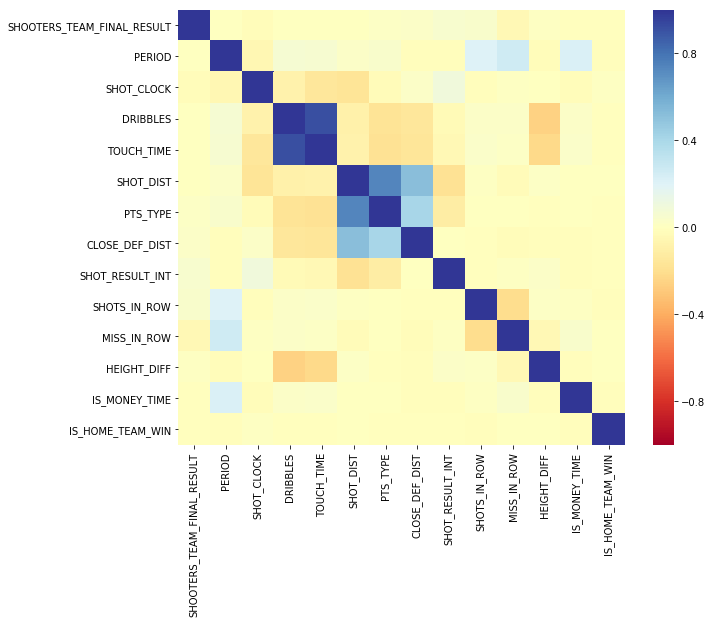

In [15]:
numericColumnsDf = shotsLogData.select_dtypes(include=[np.number])
plt.rcParams['figure.figsize'] = (10.0, 8.0)
sns.set_style()
corr = numericColumnsDf.corr()
sns.heatmap(corr,cmap="RdYlBu",vmin=-1,vmax=1)
plt.savefig('corrMap.png')


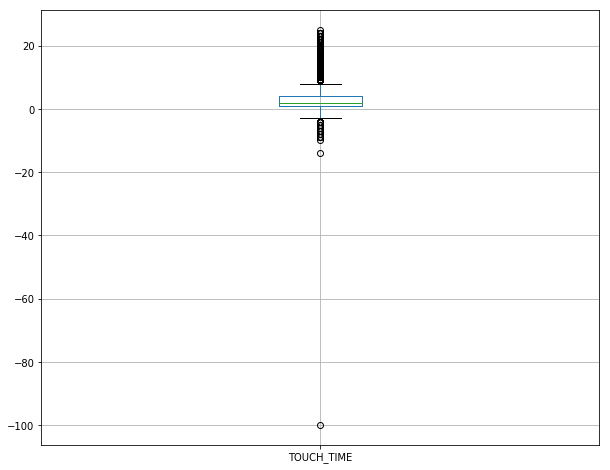

In [16]:

#show box plot of 'strange behaviour' columns)
shotsLogData.boxplot(column=['TOUCH_TIME'])

plt.savefig('BoxPlotTouchTime.png')

In [17]:
#show number of records by dribbles

shotsLogData.groupby(['DRIBBLES']).size()


DRIBBLES
0     45886
1     13924
2      9996
3      5667
4      3747
5      2656
6      2086
7      1705
8      1344
9      1115
10      952
11      770
12      626
13      510
14      359
15      263
16      236
17      168
18      130
19      118
20       95
21       99
22       64
23       62
24       31
25       25
26       12
27       11
28        8
29        1
30        5
31        1
32        1
dtype: int64

In [18]:

# removing shots that are errors/outliers shots
cleanedDataShots=shotsLogData[(shotsLogData['SHOT_DIST']<=9) & (shotsLogData['DRIBBLES']<=21) & (shotsLogData['CLOSE_DEF_DIST']<=7) & (shotsLogData['TOUCH_TIME']>=0) & (shotsLogData['TOUCH_TIME']<18) & (shotsLogData['PERIOD']<=5) & (shotsLogData['SHOT_CLOCK']<=20)]

cleanedDataShots.to_csv("cleanedDataShots.csv",index=False)
cleanedDataShots= pd.read_csv('cleanedDataShots.csv')


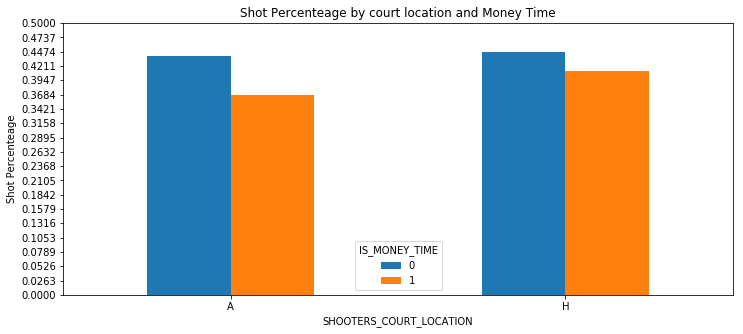

In [19]:



ax=cleanedDataShots.groupby(['SHOOTERS_COURT_LOCATION','IS_MONEY_TIME']).mean()['SHOT_RESULT_INT'].unstack().plot.bar(yticks=np.linspace(0,0.5,20),figsize=(12, 5),rot=0)
ax.set_title('Shot Percenteage by court location and Money Time')
ax.set_ylabel('Shot Percenteage')
plt.savefig('ShotPercenteageByCourtLocationMoneyTime.png')

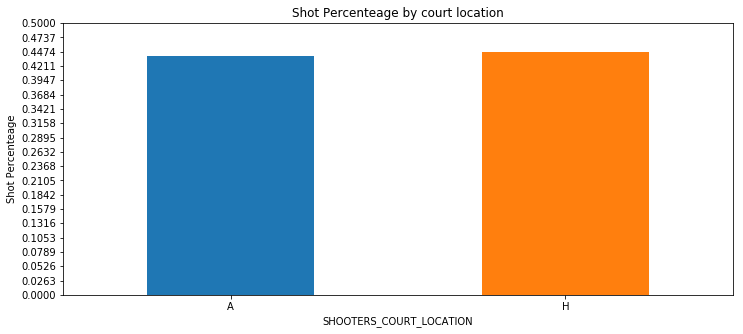

In [20]:


ax=cleanedDataShots.groupby(['SHOOTERS_COURT_LOCATION']).mean()['SHOT_RESULT_INT'].plot.bar(yticks=np.linspace(0,0.5,20),figsize=(12, 5),rot=0)
ax.set_title('Shot Percenteage by court location')
ax.set_ylabel('Shot Percenteage')
plt.savefig('ShotPercenteageByCourtLocation.png')

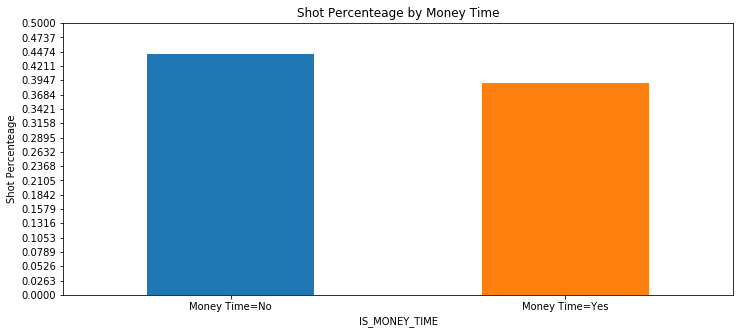

In [21]:


ax=cleanedDataShots.groupby(['IS_MONEY_TIME']).mean()['SHOT_RESULT_INT'].plot.bar(yticks=np.linspace(0,0.5,20),figsize=(12, 5),rot=0)
ax.set_title('Shot Percenteage by Money Time')
ax.set_ylabel('Shot Percenteage')
ax.set_xticklabels(['Money Time=No','Money Time=Yes'])
plt.savefig('ShotPercenteageByMoneyTime.png')

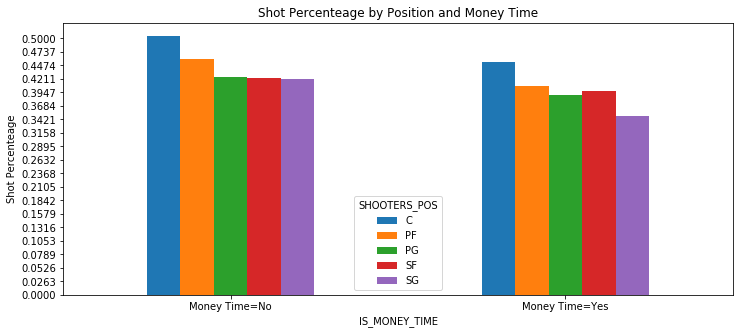

In [22]:


ax=cleanedDataShots.groupby(['IS_MONEY_TIME','SHOOTERS_POS']).mean()['SHOT_RESULT_INT'].unstack().plot.bar(yticks=np.linspace(0,0.5,20),figsize=(12, 5),rot=0)
ax.set_title('Shot Percenteage by Position and Money Time')
ax.set_ylabel('Shot Percenteage')
ax.set_xticklabels(['Money Time=No','Money Time=Yes'])
plt.savefig('ShotPercenteageByPositionMoneyTime.png')

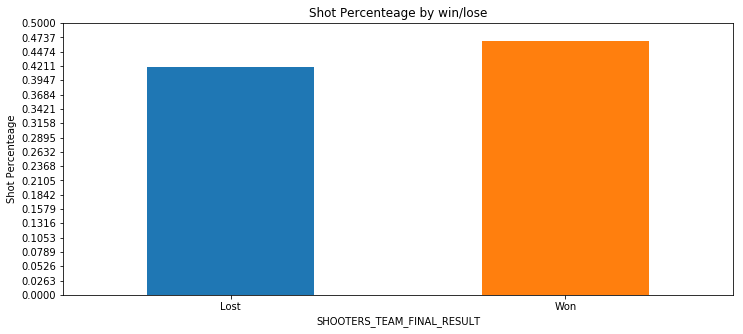

In [23]:


ax=cleanedDataShots.groupby(['SHOOTERS_TEAM_FINAL_RESULT']).mean()['SHOT_RESULT_INT'].plot.bar(yticks=np.linspace(0,0.5,20),figsize=(12, 5),rot=0)
ax.set_title('Shot Percenteage by win/lose')
ax.set_ylabel('Shot Percenteage')
ax.set_xticklabels(['Lost','Won'])
plt.savefig('ShotPercenteageByWinLose.png')

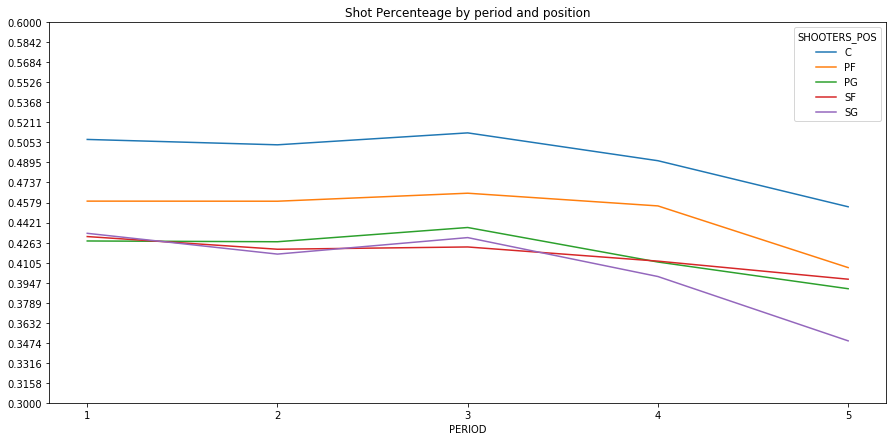

In [24]:

ax=cleanedDataShots.groupby(['PERIOD','SHOOTERS_POS']).mean()['SHOT_RESULT_INT'].unstack().plot(xticks=cleanedDataShots['PERIOD'].unique(),yticks=np.linspace(0.3,0.6,20),rot=0,figsize=(15,7))
ax.set_title('Shot Percenteage by period and position')
plt.savefig('ShotPercenteageByPeriodPosition.png')

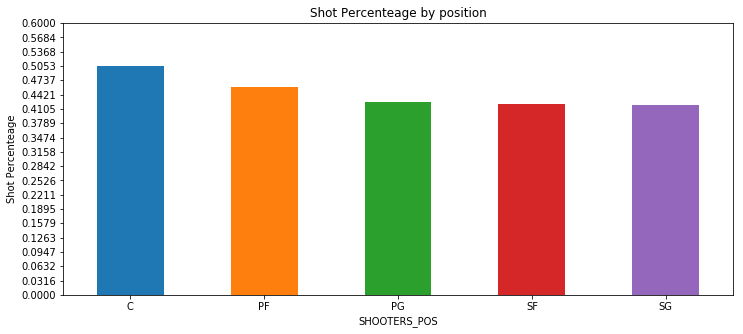

In [25]:


ax=cleanedDataShots.groupby(['SHOOTERS_POS']).mean()['SHOT_RESULT_INT'].plot.bar(yticks=np.linspace(0,0.6,20),figsize=(12, 5),rot=0)
ax.set_title('Shot Percenteage by position')
ax.set_ylabel('Shot Percenteage')
plt.savefig('ShotPercenteageByPosition.png')

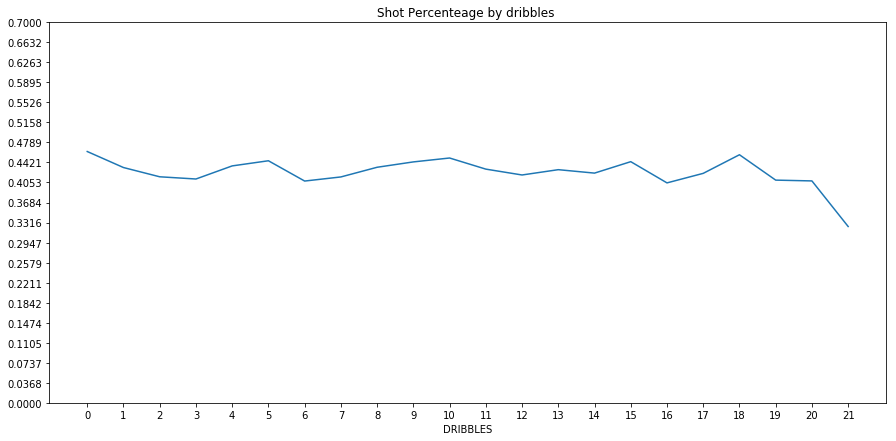

In [26]:

ax=cleanedDataShots.groupby(['DRIBBLES']).mean()['SHOT_RESULT_INT'].plot(xticks=cleanedDataShots['DRIBBLES'].unique(),yticks=np.linspace(0,0.7,20),rot=0,figsize=(15,7))
ax.set_title('Shot Percenteage by dribbles ')
plt.savefig('ShotPercenteageByDribbles.png')

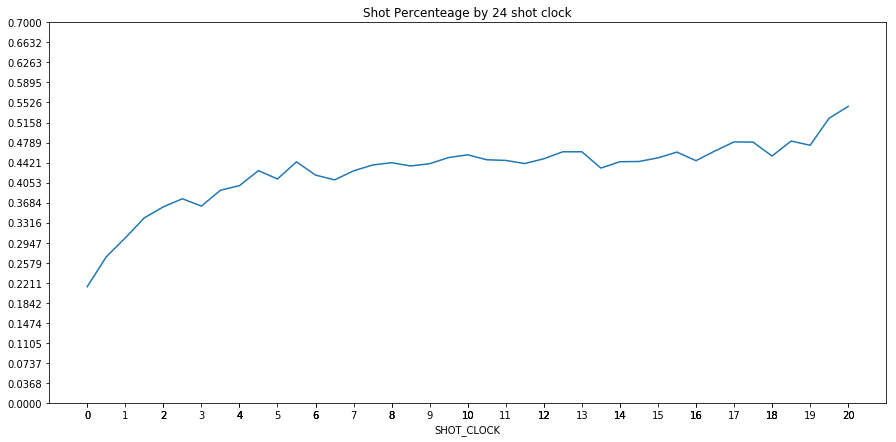

In [27]:

ax=cleanedDataShots.groupby(['SHOT_CLOCK']).mean()['SHOT_RESULT_INT'].plot(xticks=cleanedDataShots['SHOT_CLOCK'].unique().round(),yticks=np.linspace(0,0.7,20),rot=0,figsize=(15,7))
ax.set_title('Shot Percenteage by 24 shot clock')
plt.savefig('ShotPercenteageBy24Clock.png')

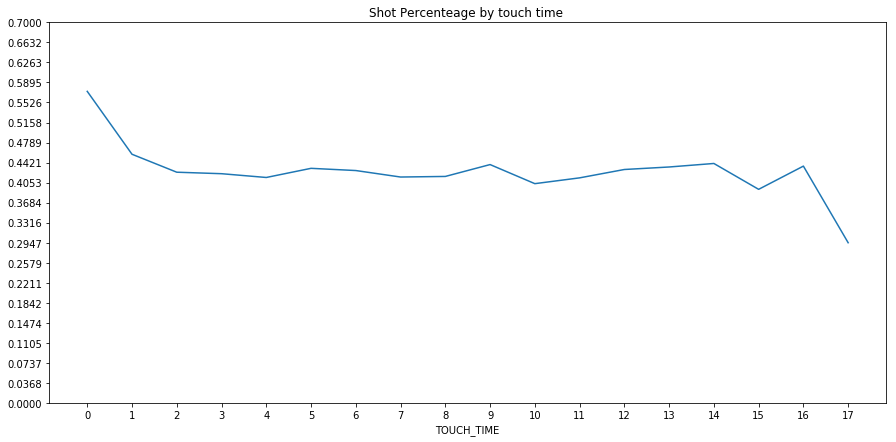

In [28]:

ax=cleanedDataShots.groupby(['TOUCH_TIME']).mean()['SHOT_RESULT_INT'].plot(xticks=cleanedDataShots['TOUCH_TIME'].unique(),yticks=np.linspace(0,0.7,20),rot=0,figsize=(15,7))
ax.set_title('Shot Percenteage by touch time ')
plt.savefig('ShotPercenteageTouchTime.png')

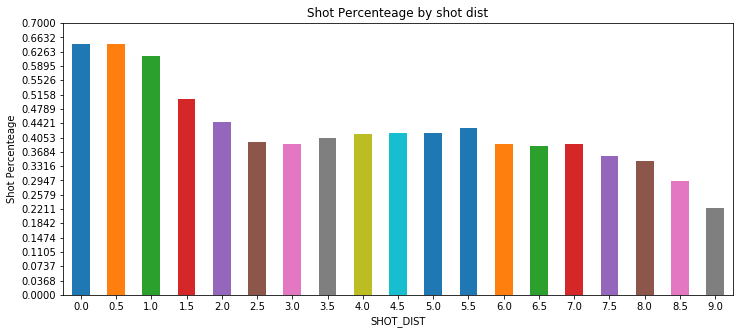

In [29]:

ax=cleanedDataShots.groupby(['SHOT_DIST']).mean()['SHOT_RESULT_INT'].plot.bar(yticks=np.linspace(0,0.7,20),figsize=(12, 5),rot=0)
ax.set_title('Shot Percenteage by shot dist')
ax.set_ylabel('Shot Percenteage')
plt.savefig('ShotPercenteageShotDist.png')


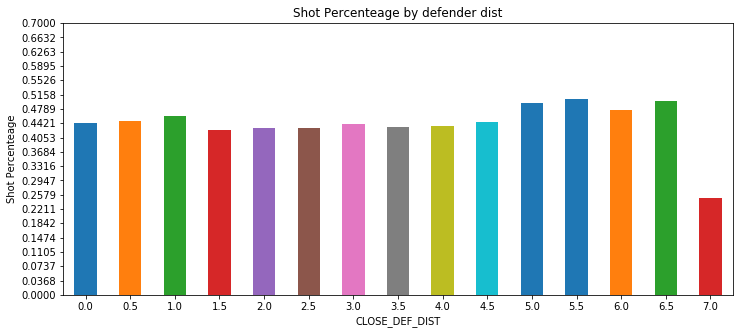

In [30]:

ax=cleanedDataShots.groupby(['CLOSE_DEF_DIST']).mean()['SHOT_RESULT_INT'].plot.bar(yticks=np.linspace(0,0.7,20),figsize=(12, 5),rot=0)
ax.set_title('Shot Percenteage by defender dist')
ax.set_ylabel('Shot Percenteage')
plt.savefig('ShotPercenteageDefenderDist.png')


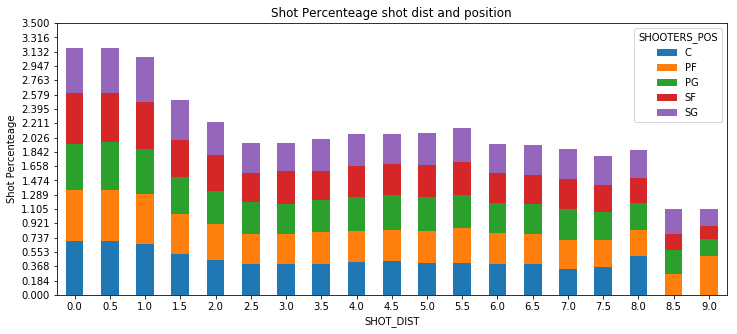

In [31]:

ax=cleanedDataShots.groupby(['SHOT_DIST','SHOOTERS_POS']).mean()['SHOT_RESULT_INT'].unstack().plot.bar(stacked=True,xticks=cleanedDataShots['SHOT_DIST'].unique(),yticks=np.linspace(0,3.5,20),figsize=(12, 5),rot=0)
ax.set_title('Shot Percenteage shot dist and position')
ax.set_ylabel('Shot Percenteage')
plt.savefig('ShotPercenteageShotDistPosition.png')


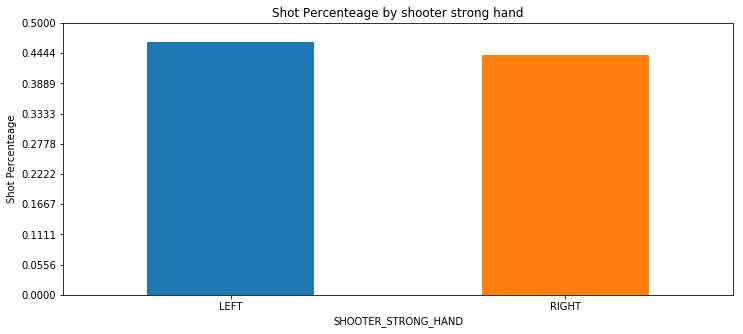

In [32]:

ax=cleanedDataShots.groupby(['SHOOTER_STRONG_HAND']).mean()['SHOT_RESULT_INT'].plot.bar(yticks=np.linspace(0,0.5,10),figsize=(12, 5),rot=0)
ax.set_title('Shot Percenteage by shooter strong hand')
ax.set_ylabel('Shot Percenteage')
plt.savefig('ShotPercenteageByShooterStrongHand.png')


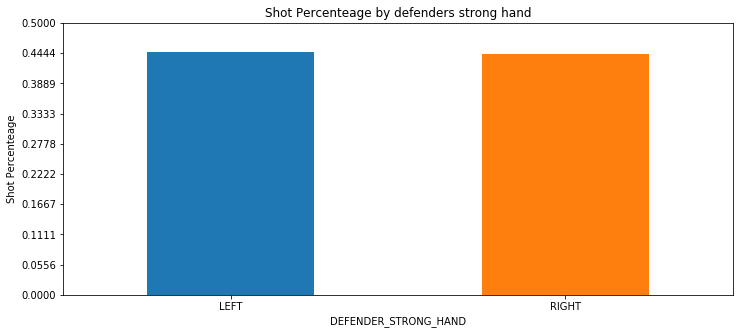

In [33]:

ax=cleanedDataShots.groupby(['DEFENDER_STRONG_HAND']).mean()['SHOT_RESULT_INT'].plot.bar(yticks=np.linspace(0,0.5,10),figsize=(12, 5),rot=0)
ax.set_title('Shot Percenteage by defenders strong hand')
ax.set_ylabel('Shot Percenteage')
plt.savefig('ShotPercenteageByDefendersStrongHand.png')


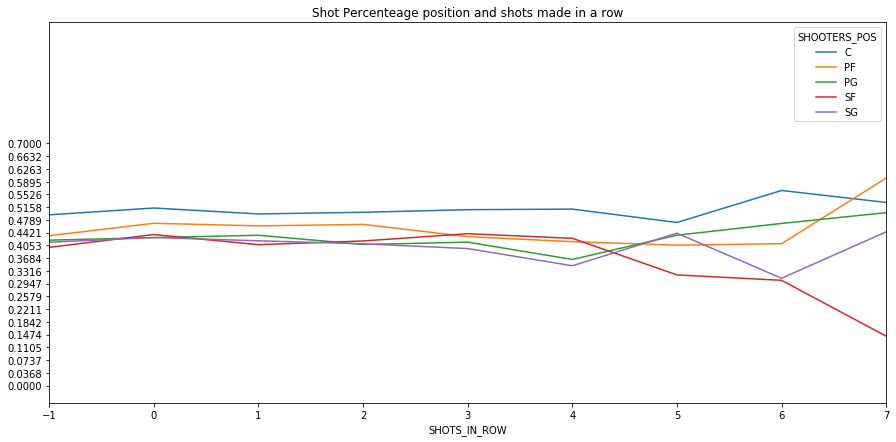

In [34]:

ax=cleanedDataShots.groupby(['SHOTS_IN_ROW','SHOOTERS_POS']).mean()['SHOT_RESULT_INT'].unstack().plot(xticks=cleanedDataShots['SHOTS_IN_ROW'].unique(),yticks=np.linspace(0,0.7,20),rot=0,figsize=(15,7))
ax.set_title('Shot Percenteage position and shots made in a row')
ax.set_xlim((-1, 7))
plt.savefig('ShotPercenteagePositionAndShotsMadeInRow.png')


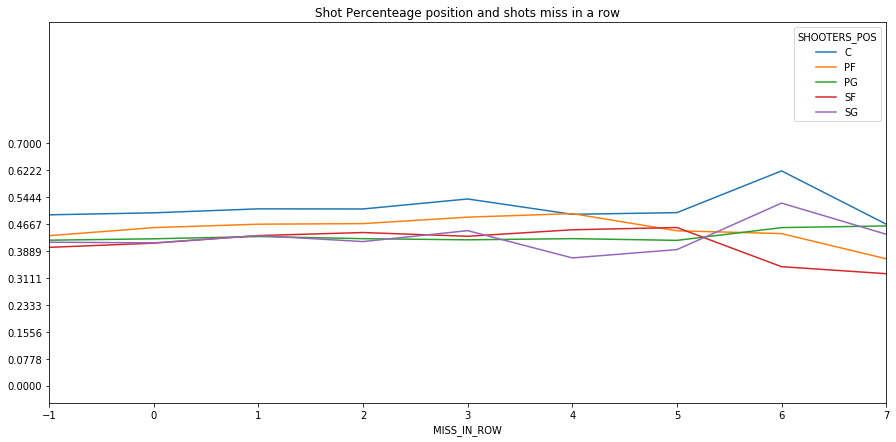

In [35]:

ax=cleanedDataShots.groupby(['MISS_IN_ROW','SHOOTERS_POS']).mean()['SHOT_RESULT_INT'].unstack().plot(xticks=cleanedDataShots['SHOTS_IN_ROW'].unique(),yticks=np.linspace(0,0.7,10),rot=0,figsize=(15,7))
ax.set_title('Shot Percenteage position and shots miss in a row')
ax.set_xlim((-1, 7))
plt.savefig('ShotPercenteagePositionAndShotsMissInRow.png')


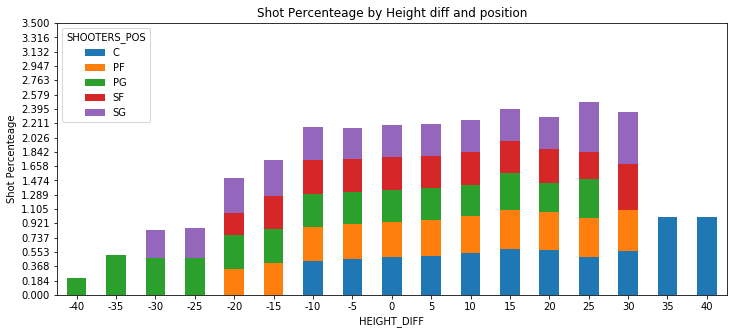

In [36]:

ax=cleanedDataShots.groupby(['HEIGHT_DIFF','SHOOTERS_POS']).mean()['SHOT_RESULT_INT'].unstack().plot.bar(stacked=True,xticks=cleanedDataShots['SHOT_DIST'].unique(),yticks=np.linspace(0,3.5,20),figsize=(12, 5),rot=0)
ax.set_title('Shot Percenteage by Height diff and position')
ax.set_ylabel('Shot Percenteage')
plt.savefig('ShotPercenteageByHeightDiffPosition.png')


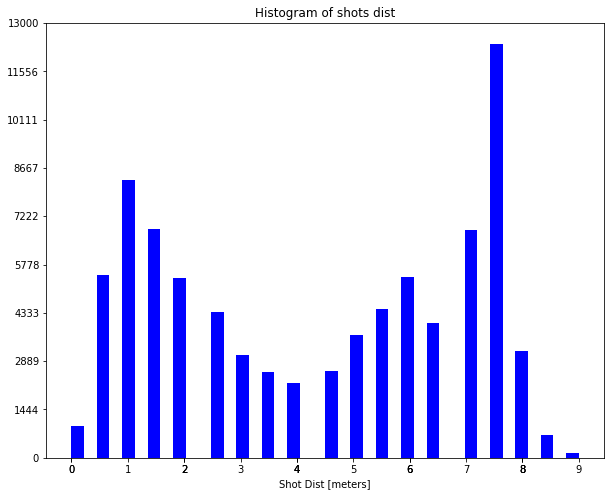

In [37]:
fig = plt.figure()
ax = fig.gca()
ax.hist(cleanedDataShots['SHOT_DIST'], bins=40, color='blue')
ax.set_xticks(cleanedDataShots['SHOT_DIST'].unique().round())
ax.set_yticks(np.linspace(0,13000,10))


ax.set_title('Histogram of shots dist')
ax.set_xlabel('Shot Dist [meters]')
plt.savefig('HistogramShotsDist.png')


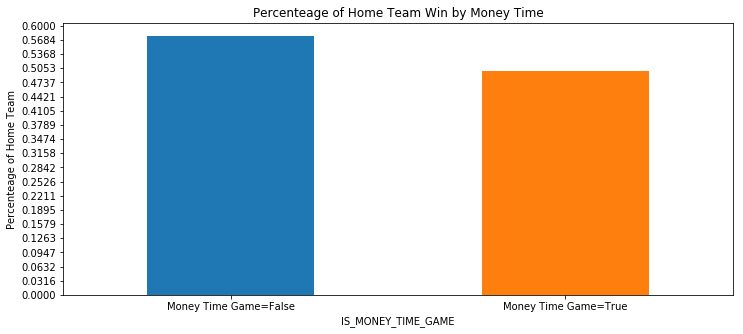

In [38]:

dfByGame= pd.read_csv('dfByMatch.csv')

ax=dfByGame.groupby(['IS_MONEY_TIME_GAME']).mean()['IS_HOME_TEAM_WIN'].plot.bar(yticks=np.linspace(0,0.6,20),figsize=(12, 5), rot=0)
ax.set_xticklabels(['Money Time Game=False','Money Time Game=True'])
ax.set_title('Percenteage of Home Team Win by Money Time')
ax.set_ylabel('Percenteage of Home Team')
plt.savefig('PercenteageHomeTeamWinMoneyTime.png')


In [39]:
playersData=cleanedDataShots[(cleanedDataShots.SHOOTER_NAME=="kobe bryant") | (cleanedDataShots.SHOOTER_NAME=="lebron james") ]
playersData.to_csv("playersData.csv",index=False)
playersData= pd.read_csv('playersData.csv')

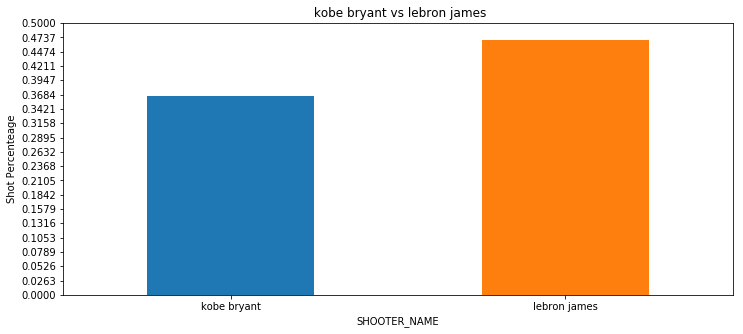

In [40]:
ax=playersData.groupby(['SHOOTER_NAME']).mean()['SHOT_RESULT_INT'].plot.bar(yticks=np.linspace(0,0.5,20),figsize=(12, 5),rot=0)
ax.set_title(' kobe bryant vs lebron james')
ax.set_ylabel('Shot Percenteage')
plt.savefig('ShotPercenteageByPlayer.png')

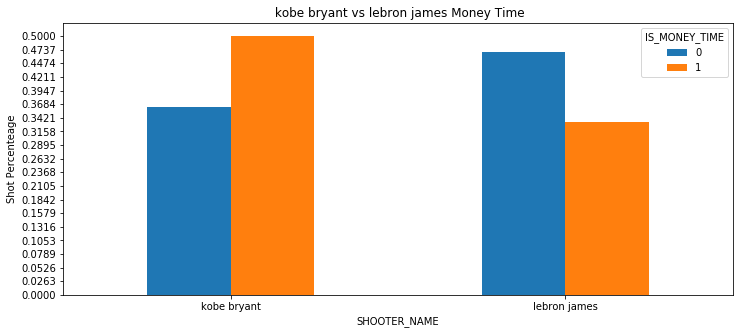

In [41]:
ax=playersData.groupby(['SHOOTER_NAME','IS_MONEY_TIME']).mean()['SHOT_RESULT_INT'].unstack().plot.bar(yticks=np.linspace(0,0.5,20),figsize=(12, 5),rot=0)
ax.set_title(' kobe bryant vs lebron james Money Time')
ax.set_ylabel('Shot Percenteage')
plt.savefig('ShotPercenteageByPlayerMoneyTime.png')

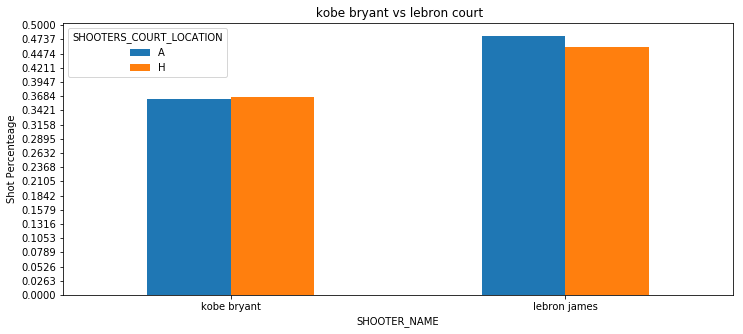

In [42]:
ax=playersData.groupby(['SHOOTER_NAME','SHOOTERS_COURT_LOCATION']).mean()['SHOT_RESULT_INT'].unstack().plot.bar(yticks=np.linspace(0,0.5,20),figsize=(12, 5),rot=0)
ax.set_title(' kobe bryant vs lebron court')
ax.set_ylabel('Shot Percenteage')
plt.savefig('ShotPercenteageByPlayerCourt.png')